# Real Estate Image Classification

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.image as img
import cv2
import pickle
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten,Input,Activation,BatchNormalization,MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler, CSVLogger
from skimage import exposure
from PIL import Image
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from tensorflow.python.keras import optimizers
import keras
from sklearn.metrics import accuracy_score

In [ ]:
#  Dataset: https://drive.google.com/u/0/uc?id=0B761qYXle4lYZHlMQ01rTEtva3M&export=download
!wget --header="Host: doc-0k-bg-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.67 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en;q=0.9,en-GB;q=0.8,en-US;q=0.7,hi;q=0.6,mr;q=0.5" --header="Referer: https://drive.google.com/" --header="Cookie: AUTH_nhtum9f1ag7kdr0qugr9r31ti1s9s7te_nonce=l4ktp49hd3oju" --header="Connection: keep-alive" "https://doc-0k-bg-docs.googleusercontent.com/docs/securesc/t37stmq9qp3lckemhlhheg05aaivnj9f/s507lh44ukn6hsq4vkb6c2heh77d1api/1653587100000/08117333789497023805/10359008037252623191/0B761qYXle4lYZHlMQ01rTEtva3M?e=download&ax=ACxEAsYYC_Z0CnNbZWr7kCylVFA9JzoFu-HIDbM87xDZLqEypprAWpkUiAEqmFix4JcdY4z6AolJzvEL9bfXMUr1Q_Os4H5g_TgKZM39m6H0VrcOY35nkEUhMI9zCLR_keF5BywwrAedRn8vtz1oL6emFYOZvW5KDligci6AFfnvLGSAmqIculXbg7_L2y4tDmcuSerJ5wvfjK5uJGM-U12b3Ve_1w1atamm55ajuFRJzx11d3HJYuPFwu9auIFh7p18iqh57odkgu8j4P6_On_ritDxr9eoXgL81nSDiYDezjF1wL-cseRxCtRw8ly6uZ7Hl_brRSaJg0Wy0AC0HyodEExepB0HCA8fY3zkGbCjsdJoMSqkt2f5SniKoKUzMyT1vJhozXL3bgqnK9untDjlNagPnlcigK9ZYaGVniWZfGncp5pLOs6zbL4hMZTi3E3Nh-M5VbnR7wP3sIF5PzMJX0l-PE40YLYOxlmHiI2FOiYPUr-qYSKk81CY4p8bmzwlVwRz4jM616vO6-8sIIghRNXujkcBePZ5RGzFLfDuesQTqTrR3qtv3rW_XFRDte1ly62zL9ljQE_WNvQS8tH1MVKDRAUQQSLclmWgLqt4Y0C0PiiprukHPP9t9xVF7sX0MoZ5Jzh9p4tDr9BA8bBIvYnkOSq1v3p9ETTjfwBH6ALRzH2Gyu2cZImHxzaMQDKQYyQCIn_WRErLB_EoCY-0AOUP_ORNC13A77WhvkjyAIVNIaK0qvFKaEtvCVzngj4deCyVt5PlidO9TMdbJChQEWQr7Mr-iz1BI2WE0XG10uR-3wiuqQ&authuser=0&nonce=l4ktp49hd3oju&user=10359008037252623191&hash=4fh070ttugk03sqgtpr7231f0fd4gldo" -c -O 'REI-Dataset.zip'

In [ ]:
!unzip REI-Dataset -d "dataset"

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
with open("drive/MyDrive/Self Case study/Real estate image/preprocessed_data","rb") as loc:
  X_train, X_test = pickle.load(loc)

## Final Pipeline:

In [9]:
def classify(pic):
  '''
  This function takes image path as an input and return predicted class label
  '''
  with open("/content/drive/MyDrive/Self Case study/Real estate image/Saved models/resnet_2_new", "r") as json_file:
    model = json_file.read()
  with open("/content/drive/MyDrive/Self Case study/Real estate image/Deployment/class_dicts", "rb") as loc:
    vocab_dict, vocab_dict_op = pickle.load(loc)

  model = model_from_json(model)
  model.load_weights('/content/drive/MyDrive/Self Case study/Real estate image/Saved models/resnet_new.h5')
  model.compile(optimizer= 'adam' ,loss="categorical_crossentropy",metrics=["accuracy"])

  img = cv2.imread(pic)
  img = cv2.resize(img, dsize=(224,224))/255
  pred = model.predict(img.reshape(1,224,224,3))
  pred_label = vocab_dict_op[np.argmax(pred)]

  return pred_label

'kitchen'

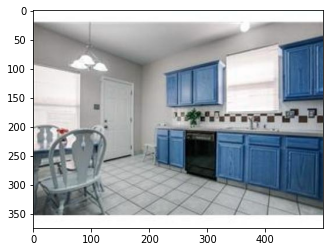

In [15]:
# classify random image from test data 
num = np.random.randint(0,len(X_test))
image = X_test['path'].values[num]
img = cv2.imread(image)
plt.imshow(img)
classify(image)

In [36]:
def evaluate(pic, label):
  '''
  This function takes image path as an input and return evaluation result.
  '''
  with open("/content/drive/MyDrive/Self Case study/Real estate image/Saved models/resnet_2_new", "r") as json_file:
    model = json_file.read()
  with open("/content/drive/MyDrive/Self Case study/Real estate image/Deployment/class_dicts", "rb") as loc:
    vocab_dict, vocab_dict_op = pickle.load(loc)

  model = model_from_json(model)
  model.load_weights('/content/drive/MyDrive/Self Case study/Real estate image/Saved models/resnet_new.h5')
  model.compile(optimizer= 'adam' ,loss="categorical_crossentropy",metrics=["accuracy"])

  img = cv2.imread(pic)
  img = cv2.resize(img, dsize=(224,224))/255
  pred = model.predict(img.reshape(1,224,224,3))
  confidence = round(np.max(pred)*100, 2)
  pred = np.argmax(pred)
  actual = vocab_dict[label]
  accuracy = accuracy_score([actual],[pred])
  
  return accuracy, confidence

Accuracy: 1.0, Confidence: 100.0%


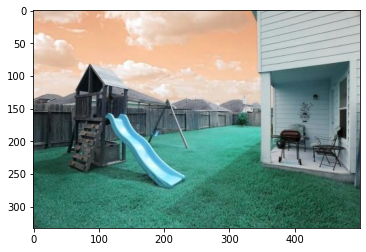

In [40]:
# evaluate result on random image from test data 
num = np.random.randint(0,len(X_test))
image = X_test['path'].values[num]
label = X_test['label'].values[num]
img = cv2.imread(image)
plt.imshow(img)
accu, confi = evaluate(image,label)
print("Accuracy: {}, Confidence: {}%".format(accu, confi))